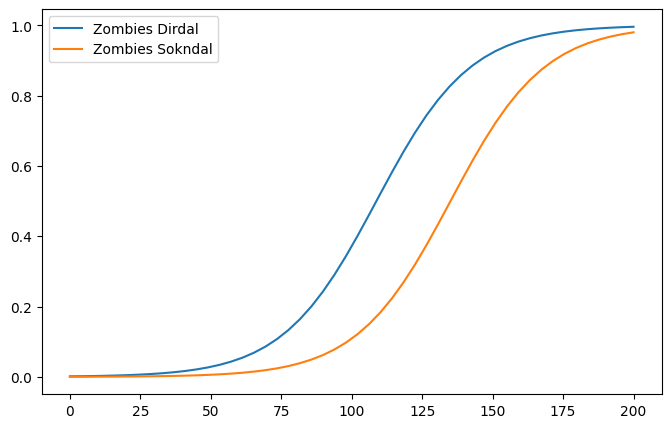

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

beta = 0.06
N_dirdal = 683
N_sokndal = 3305
Z0 = 1


def SZ_solution(t, N, Z0=1):
    S0 = N - Z0
    S = (S0 * (S0/Z0) * np.exp(-beta*t)) / (1 + (S0/Z0) * np.exp(-beta*t))
    Z = (S0 + Z0) / (1 + (S0/Z0) * np.exp(-beta*t))
    return S, Z

t = np.linspace(0, 200)

S_d, Z_d = SZ_solution(t, N_dirdal)
S_s, Z_s = SZ_solution(t, N_sokndal)

#må dele på befolkning for å få like reprensativt tall
Z_d_frac = Z_d / N_dirdal
Z_s_frac = Z_s / N_sokndal

# plotting
plt.figure(figsize=(8,5))
plt.plot(t, Z_d_frac, label="Zombies Dirdal")
plt.plot(t, Z_s_frac, label="Zombies Sokndal")


plt.legend()

plt.show()

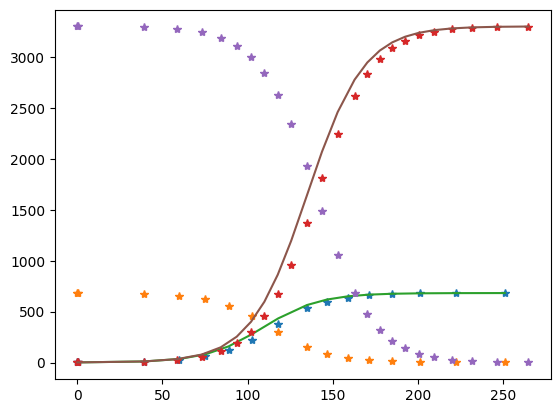

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class zombie_outbreak:
    def __init__(self,location, population,beta,Z0 = 1):
        self.Location = location
        self.Population = population
        self.c0 = np.array([Z0,self.Population-Z0])
        self.z0 = Z0
        self.beta = beta

    def step(self, t, c_old, dt, f, method, *args, **kwargs):
        """
        Awesome doc string
        """
        if method == 'Euler':
            return dt*f(t, c_old, *args, **kwargs)
        elif method == 'RK2':
            k1 = np.array(dt*f(t, c_old, *args, **kwargs))
            return dt*f(t+dt*0.5, c_old + 0.5*k1, *args, **kwargs)
        else:
            raise ValueError('Method ot implemented') 

    def ode_solver_adaptiv(self, t0, t_final, eps, f, method, *args, **kwargs):
        '''En grunnleggende ODE solver
            Input
            -----
            t0: float, starting time
            t_final: float, end time
            eps: float, accuracy
            f: ode function (rhs) f(t,c,tau)
            tau: float, a parameter

            Output
            -----
            t, c'''
        c = [self.c0]
        t = [t0]
        dt_old = 1e-1
        if method == "Euler":
            p=1
        elif method == "RK2":
            p = 2
        else:
            assert ValueError("Method is not implemented")
            
        while t[-1] < t_final:
            c_old = c[-1]
            eps_calc = 10*eps #just to enter while loop
            while eps_calc > eps:
                dt = dt_old
                c_long = c_old + self.step(t[-1], c_old, dt, f, method, *args, **kwargs)
                c_half = c_old + self.step(t[-1], c_old, 0.5*dt, f, method, *args, **kwargs)
                c_two_half = c_half + self.step(t[-1]+0.5*dt, c_half, 0.5*dt, f, method, *args, **kwargs)
                eps_calc = np.linalg.norm((c_long-c_two_half)/(2**p-1))
                dt_old = dt*(eps/eps_calc)**(1/(p+1))
            c.append(c_two_half)
            t.append(t[-1]+dt)
        return np.array(t), np.array(c)



    def rhs_z(self, t,c):
        return np.array([self.beta*c[0]*(1-c[0]/self.Population), -self.beta*c[1]*(1-c[1]/self.Population)])
    
    def SZ_solution(self,t):
        S0 = self.Population - self.z0
        S = (S0 * (S0/self.z0) * np.exp(-self.beta*t)) / (1 + (S0/self.z0) * np.exp(-self.beta*t))
        Z = (S0 + self.z0) / (1 + (S0/self.z0) * np.exp(-self.beta*t))
        return S, Z
    
    def solve(self,t0,t,eps, method):
        t, Z = self.ode_solver_adaptiv(t0, t, eps, self.rhs_z, method)
        _, Z_d = self.SZ_solution(t)
        plt.plot(t, Z,'*', label=f"Zombies {self.Location}")
        plt.show
        plt.plot(t, Z_d, label=f"Zombies {self.Location} numerical")
        plt.show

dt = 0.1
eps = 1
dirdal = zombie_outbreak("Dirdal", 683,0.06)
sokndal = zombie_outbreak("sokndal", N_sokndal,0.06)
dirdal.solve(0,250,eps, "RK2")
sokndal.solve(0,250,eps, "RK2")